Making a decision about ComEd hourly pricing
---------------------------------

ComEd, our power company, has started offering hourly pricing for electricity. I wanted to see whether it would be worth switching. I'm going to show what I did, and teach a few principles about web scraping and data analysis along the way.

The TL;DR is that hourly pricing looks good initially but there's a "Capacity Charge" fee that is surprisingly high and may make hourly pricing unwise.

Finding the data
--------------

In the original version of this post, I showed how to use a hidden API to download my usage data. I later realized that ComEd makes this data available in a CSV file via what's called "Green Button Data" and can be downloaded from [here](https://secure.comed.com/MyAccount/MyBillUsage/pages/secure/GreenButtonConnectDownloadMyData.aspx) if you are logged in.

For this analysis, I use all my data from 1/1/2017 to 12/31/2017.

In [6]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

We load libraries and then load the Green Button Data. Make sure to change this path to where you saved the data.

In [9]:
usage = pd.read_csv('/PATH/TO/cec_electric_interval_data_Service 1_2017-01-01_to_2017-12-31.csv',
           skiprows = 5,
                   parse_dates=[['DATE', 'START TIME']])
# Remove the dollar sign from the cost column
usage.COST = usage.COST.apply(lambda x: float(re.sub('\$', '', x)))

In [14]:
# You may have a few negative values. I figured out that these are peak savings day rewards.
usage.COST.sort_values().head()

12696   -2.49
11594   -2.48
12360   -0.88
5891     0.00
3944     0.00
Name: COST, dtype: float64

In [15]:
# We take the startTime and make it the index of the dataframe
usage = usage.set_index(pd.DatetimeIndex(usage['DATE_START TIME']))
# And then just keep the columns we're interested in - the energy used and cost.
usage = usage[['USAGE', 'COST']]

Always look at the raw data to make sure it looks reasonable.

In [22]:
usage.head()

,USAGE,COST
DATE_START TIME,,
2017-01-01 00:00:00,0.11,0.01
2017-01-01 00:30:00,0.10,0.01
2017-01-01 01:00:00,0.18,0.02
2017-01-01 01:30:00,0.10,0.01
2017-01-01 02:00:00,0.07,0.01


We now have usage.USAGE, which is a pandas Series of how much energy I used each hour of each day in 2017.

Let's plot how much we used per week.

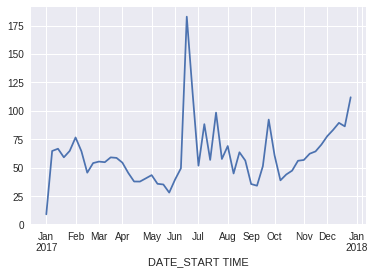

In [16]:
# Resample takes a time series, and aggregates it by the string passed to it. 'W' is for week.
usage.USAGE.resample('W').sum().plot() 

Next, we can get the prices. This is from a public API.

We use the wonderful `requests` library to download and parse the JSON output of this API.

In [29]:

params = {'datestart': '201701010000',
         'dateend': '201801010000'
         }

r = requests.get('https://hourlypricing.comed.com/api?type=5minutefeed',
                 params = params)

        
json_prices = r.json()


In [38]:
prices = pd.DataFrame(json_prices)
# This time, the date is a timestamp, but we still convert it to datetime and save it as the index
prices = prices.set_index(pd.DatetimeIndex(
    prices['millisUTC'].apply(lambda x: datetime.utcfromtimestamp(int(x)/1000) - pd.Timedelta(hours = 6)))) # Adjust to this timezone
# And again, we discard what we don't need and save just the prices as a series
prices = prices.price.apply(float)

I think digging into this price data could be really interesting, but this is a superficial plot of the weekly prices. Notice that the average weekly price never gets above 4.5 cents per kwh, which is much lower than the ~6.5-7 cents that you get with flat pricing.

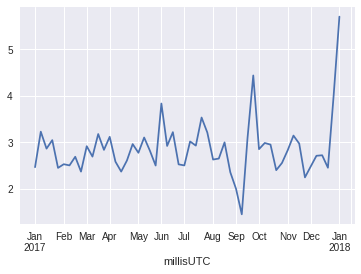

In [39]:
prices.resample('W').mean().plot()

I then put all of these into a dataframe, to make the dates match up.

In [40]:
mean_prices = prices.resample('H').mean()
tot_usage = usage.resample('H').sum()
df = pd.DataFrame({'usage' : tot_usage.USAGE,
                   'actual_cost': tot_usage.COST,
                  'hourly_price' : mean_prices/100})


In [6]:
# Simple function to change the datetime string into a datetime object and change to UTC
def to_dt(s):
    s = s[:-3] + s[-2:]
    with_tz = datetime.strptime(s, '%Y-%m-%dT%H:%M:%S.000%z')
    return (with_tz - with_tz.utcoffset()).replace(tzinfo = None)

It's always a good idea to make sure that the data look good. Let's check for NAs:


In [41]:
df[df.isna().any(axis=1)]

,actual_cost,hourly_price,usage
DATE_START TIME,,,
2017-03-19 16:00:00,0.03,NaN,0.20
2017-03-19 17:00:00,0.02,NaN,0.18
2017-03-19 18:00:00,0.03,NaN,0.23
2017-03-19 19:00:00,0.03,NaN,0.25
2017-03-29 23:00:00,0.02,NaN,0.15
2017-03-30 00:00:00,0.02,NaN,0.12
2017-03-30 01:00:00,0.01,NaN,0.11
2017-03-30 02:00:00,0.02,NaN,0.13
2017-03-30 03:00:00,0.02,NaN,0.14


The prices are missing for a few days in March, which is odd. I have no idea why there is one missing row in November.

There are a number of ways of dealing with missing data. For our purposes, I'm looking for a rough estimate, and using a linear interpolation for the rows for which we have data seems a reasonable estimate. Pandas has this built in.

In [42]:
df = df.interpolate(method='time')

This is what it looks like. It just draws a straight line from the last known data point to the next known data point.

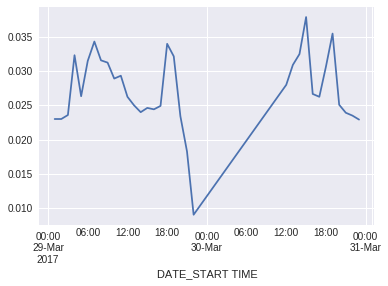

In [44]:
df.hourly_price[(df.index > '2017-03-29') & (df.index < '2017-03-31')].plot()

## Getting bounds

Let's look at the worst-case examples. Here are the 10 highest priced hours. I don't know what happened on September 20-22, but it was bad. Those prices are ~10X higher than flat rate prices

In [48]:
worst_prices = df.hourly_price.resample('H').mean().sort_values(ascending = False)
worst_prices.head(10)

DATE_START TIME
2017-09-21 12:00:00    0.744250
2017-09-21 14:00:00    0.551500
2017-07-06 13:00:00    0.397833
2017-09-21 13:00:00    0.259700
2017-12-27 23:00:00    0.253250
2017-07-27 08:00:00    0.194250
2017-12-27 07:00:00    0.189500
2017-12-31 23:00:00    0.184833
2017-09-20 15:00:00    0.174833
2017-09-20 12:00:00    0.172417
Name: hourly_price, dtype: float64

Let's put bounds on how much I might spend on electricity. For the upper bound, we imagine that whenever the highest price of the year was, we used our highest amount of electricity, during the second most expensive we used our second highest amount, etc. This is the highest total price possible for this set of prices and usage. The lower bound is similar, but assumes the lowest prices had the highest usage.

I'm also including the actual cost as reported in my green button data, and the cost calcuated based on ComEd's current price per kWh

In [66]:
hourly_cost = pd.DataFrame({'upper_bound': df.usage.sort_values(ascending = False).values * worst_prices,
                            'lower_bound': df.usage.sort_values(ascending = True).values * worst_prices,
                            'actual': df.actual_cost,
                           'curr_comed_cost': df.usage * .072})

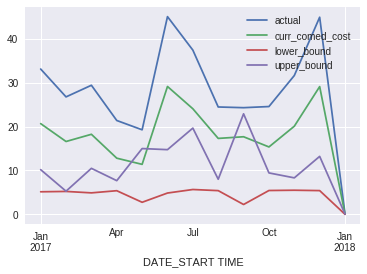

In [67]:
hourly_cost.resample('M').sum().plot()

## Beware the sneaky fees!

Even with the upper bound, the average monthly price appears to typically be well below my current price.

However, ComEd also has a new fee that applies only to hourly pricing customers, called a "Capacity Charge."*

In my case, this fee is over $15/month, which they said is fairly typical. Adding this fee may change our calculations.




\* Information I only learned after signing up for hourly pricing!

In [68]:
# Add the fee to the hourly cost numbers

monthly_data = hourly_cost.resample('M').sum()
monthly_data.upper_bound += 15
monthly_data.lower_bound += 15


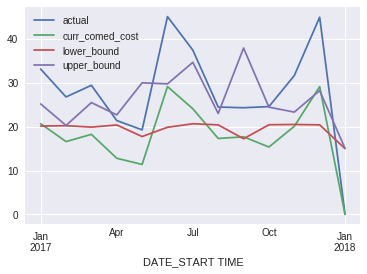

In [69]:
monthly_data.plot()

This new plot makes it clear that hourly pricing is not completely straighforward. The current ComEd cost is often below the upper and lower bounds. Indeed, before knowing about the Capacity Charge I switched to hourly pricing and so far every month I have been at a net loss compared to the flat rate.